## Goal

I find an improved implementation of anchor-word algorithm at https://aclanthology.org/D19-1504.pdf . I want to see how well it performs on a simulated dataset that slightly violates the "anchor-word" assumption. 

## Results

* The estimation is good, even when the identified "anchor words" do not satisfy the assumptions (two of them are for the same topic... I don't understand why it still works well)
* The `rectify C` step is quite important: without this step the result is much worse; 
* If we know the true C we can almost exactly recover the topic matrx and topic-topic matrix $F, A$ (In the code $B$ is the estimation for $F$). Also, the identified "anchor-words" approximately satisfy the assumption. 


In [1]:
import os
import sys
import pandas as pd
from scipy import sparse

import numpy as np
import matplotlib.pyplot as plt

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions import *
from misc import *


np.random.seed(123)

## small, uncorrelated example

I simulate a count matrix from $L, F$, with each column of $F$ has 20 words that is 100 times more expressed than the rest words. This will not satisfy the strict "anchor word" assumption, but it's close: $F_{s_k, k} >> F_{s_k, l}, \forall l \neq k$ where $s_k$ is "approximate" anchor word for topic $k$. 

In [2]:
n = 1000
p = 5000
k = 4
doc_len = 100

sim = smallsim_independent(n = n, p = p, k = k, doc_len = doc_len)
X = sparse.coo_matrix(sim["X"])
L = sim["L"]
F = sim["F"]
id_m = sim["id_m"]
C, D1, D2 = X2C(X)

C.shape

[file.bows2C] Start constructing dense C...
- Counting the co-occurrence for each document...
+ Finish constructing C and D!
  - The sum of all entries = 1.000000
  - Elapsed Time = 0.7776 seconds


(4998, 4998)

In [3]:
S, B, A, Btilde, Cbar, C_rowSums, diagR, C = factorizeC(C, K=k, rectifier='AP', optimizer='activeSet')


+ Start rectifying C...
+ Start alternating projection
  - 1-th iteration... (3.117024e-04 / 4.857925e-08)
  - 2-th iteration... (1.482565e-07 / 4.857929e-08)
  - 3-th iteration... (1.061586e-07 / 4.857932e-08)
  - 4-th iteration... (8.022487e-08 / 4.857936e-08)
  - 5-th iteration... (6.212581e-08 / 4.857939e-08)
  - 6-th iteration... (4.910836e-08 / 4.857942e-08)
  - 7-th iteration... (3.967035e-08 / 4.857945e-08)
  - 8-th iteration... (3.278401e-08 / 4.857947e-08)
  - 9-th iteration... (2.772217e-08 / 4.857949e-08)
  - 10-th iteration... (2.386173e-08 / 4.857950e-08)
  - 11-th iteration... (2.090256e-08 / 4.857952e-08)
  - 12-th iteration... (1.862261e-08 / 4.857953e-08)
  - 13-th iteration... (1.682069e-08 / 4.857954e-08)
  - 14-th iteration... (1.537568e-08 / 4.857955e-08)
  - 15-th iteration... (1.418457e-08 / 4.857956e-08)
+ Finish alternating projection
  - Elapsed seconds = 21.7141

  - Finish rectifying C! [21.714116]
+ Start finding the set of anchor bases S...
[inference.fin

## Evaulate results

* There is 1-1 correspondence between topics
* However, the recovered "anchor words" (S below) do not satisfy the "anchor word" assumption
* Still, the fitted values for $F$ (topic matrix) and $A$ (topic-topic matrix) are not bad. 

In [4]:
topic_idx = match_topics(F, B).astype(int)
topic_idx

array([3, 1, 0, 2])

In [5]:
B[S,:].round(5)

array([[4.0e-05, 0.0e+00, 0.0e+00, 0.0e+00],
       [0.0e+00, 5.0e-05, 0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 9.0e-05, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 2.3e-04]])

In [6]:
S

array([3972, 2357, 4324, 4377])

In [7]:
F[S[topic_idx],:].round(4)

array([[0.0002, 0.    , 0.    , 0.    ],
       [0.    , 0.0002, 0.    , 0.    ],
       [0.0002, 0.    , 0.    , 0.    ],
       [0.    , 0.0001, 0.    , 0.0001]])

In [8]:
# compare A and LLt/n
A_reorder = A[topic_idx,:]
A_reorder = A_reorder[:, topic_idx]
A_reorder.round(decimals=2)

array([[0.28, 0.  , 0.  , 0.  ],
       [0.  , 0.31, 0.  , 0.  ],
       [0.  , 0.  , 0.33, 0.  ],
       [0.  , 0.  , 0.  , 0.32]])

In [9]:
L = sim["L"]
(L.T.dot(L)/n).round(decimals=2)

array([[0.16, 0.02, 0.02, 0.02],
       [0.02, 0.18, 0.03, 0.02],
       [0.02, 0.03, 0.2 , 0.02],
       [0.02, 0.02, 0.02, 0.19]])

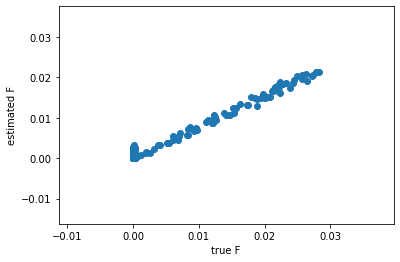

In [10]:
plt.scatter(F.flatten(), B[:,topic_idx].flatten())
plt.xlabel('true F')
plt.ylabel('estimated F') 
plt.show()

## Apply the algorithm without rectifying C`

In [11]:
C, D1, D2 = X2C(X)
S, B, A, Btilde, Cbar, C_rowSums, diagR, C = factorizeC(C, K=k, rectifier='no', optimizer='activeSet')

[file.bows2C] Start constructing dense C...
- Counting the co-occurrence for each document...
+ Finish constructing C and D!
  - The sum of all entries = 1.000000
  - Elapsed Time = 0.7600 seconds
+ Start rectifying C...
  - Finish rectifying C! [0.000000]
+ Start finding the set of anchor bases S...
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 4 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.5701 seconds

  - Finish finding S! [0.570118]
+ Start recovering the object-cluster B...
[inference.recoverB] Start recovering the object-cluster B...
  - 0-th member...
  - 500-th member...
  - 1000-th member...
  - 1500-th member...
  - 2000-th member...
  - 2500-th member...
  - 3000-th member...
  - 3500-th member...
  - 4000-th member...
  - 4500-th member...
+ Finish recovering B matrix using [activeSet]
  - 4/4998 objects are converged.
  - loss = 6.3520 (By Frobenius norm).
  - Elapsed time = 5.7594 seconds.

  - Finish

In [12]:
topic_idx = match_topics(F, B).astype(int)
topic_idx

array([3, 1, 2, 0])

There is something wrong with `recoverA` step... 

In [13]:
# compare A and LLt/n
A

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [14]:
L = sim["L"]
(L.T.dot(L)/n).round(decimals=2)

array([[0.16, 0.02, 0.02, 0.02],
       [0.02, 0.18, 0.03, 0.02],
       [0.02, 0.03, 0.2 , 0.02],
       [0.02, 0.02, 0.02, 0.19]])

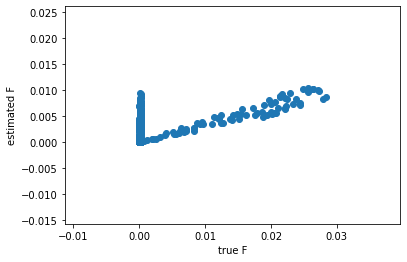

In [15]:
plt.scatter(F.flatten(), B[:,topic_idx].flatten())
plt.xlabel('true F')
plt.ylabel('estimated F') 
plt.show()

## suppose we know the true C

In [16]:
Lam = L @ F.T
C = Lam.T @ Lam
C = C/C.sum()

S, B, A, Btilde, Cbar, C_rowSums, diagR, C = factorizeC(C, K=k, rectifier='no', optimizer='activeSet')

+ Start rectifying C...
  - Finish rectifying C! [0.000000]
+ Start finding the set of anchor bases S...
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 4 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.5493 seconds

  - Finish finding S! [0.549258]
+ Start recovering the object-cluster B...
[inference.recoverB] Start recovering the object-cluster B...
  - 0-th member...
  - 500-th member...
  - 1000-th member...
  - 1500-th member...
  - 2000-th member...
  - 2500-th member...
  - 3000-th member...
  - 3500-th member...
  - 4000-th member...
  - 4500-th member...
+ Finish recovering B matrix using [activeSet]
  - 4/4998 objects are converged.
  - loss = 3.9480 (By Frobenius norm).
  - Elapsed time = 6.1010 seconds.

  - Finish recovering B! [6.100957]
+ Start recovering the cluster-cluster A...
[inference.recoverA] Start recovering the cluster-cluster A...
+ Finish recovering A!
  - [diagonal] recovery is used.
  - Elap

In [17]:
topic_idx = match_topics(F, B).astype(int)
topic_idx

array([2, 1, 0, 3])

In [18]:
# compare A and LLt/n
A_reorder = A[topic_idx,:]
A_reorder = A_reorder[:, topic_idx]
A_reorder.round(decimals=2)

array([[0.16, 0.02, 0.02, 0.02],
       [0.02, 0.18, 0.03, 0.03],
       [0.02, 0.03, 0.19, 0.03],
       [0.02, 0.03, 0.03, 0.18]])

In [19]:
L = sim["L"]
(L.T.dot(L)/n).round(decimals=2)

array([[0.16, 0.02, 0.02, 0.02],
       [0.02, 0.18, 0.03, 0.02],
       [0.02, 0.03, 0.2 , 0.02],
       [0.02, 0.02, 0.02, 0.19]])

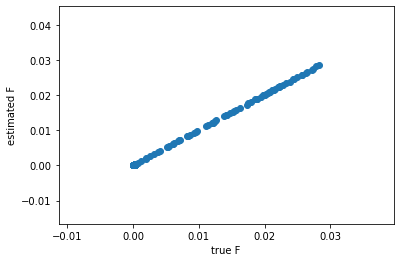

In [20]:
plt.scatter(F.flatten(), B[:,topic_idx].flatten())
plt.xlabel('true F')
plt.ylabel('estimated F') 
plt.show()

In [21]:
S

array([3903, 3029,  986,  557])

The identified "anchor-words" approximately satisfy the assumption, and the estimation is accurate. 

In [22]:
S[topic_idx]

array([ 986, 3029, 3903,  557])

In [23]:
F[S[topic_idx],:].round(4)

array([[0.0188, 0.    , 0.    , 0.0001],
       [0.    , 0.0083, 0.    , 0.    ],
       [0.    , 0.    , 0.0197, 0.0002],
       [0.0001, 0.    , 0.0003, 0.0279]])

In [24]:
B[S,:]

array([[0.01997713, 0.        , 0.        , 0.        ],
       [0.        , 0.00830997, 0.        , 0.        ],
       [0.        , 0.        , 0.01893034, 0.        ],
       [0.        , 0.        , 0.        , 0.02830351]])